Question 1


In [63]:
import pandas as pd
import numpy as np

# Charger les données
df = pd.read_csv("data/coin_Bitcoin.csv", parse_dates=["Date"], index_col="Date")

# Prendre seulement la colonne Close
close = df["Close"]

# Calcul des rendements logarithmiques
log_returns = np.log(close / close.shift(1)).dropna()




=== Tableau descriptif complet ===
        Minimum   Maximum   Moyenne  Écart-type   Kurtosis
Valeur -0.46473  0.357451  0.002016    0.042608  11.715993


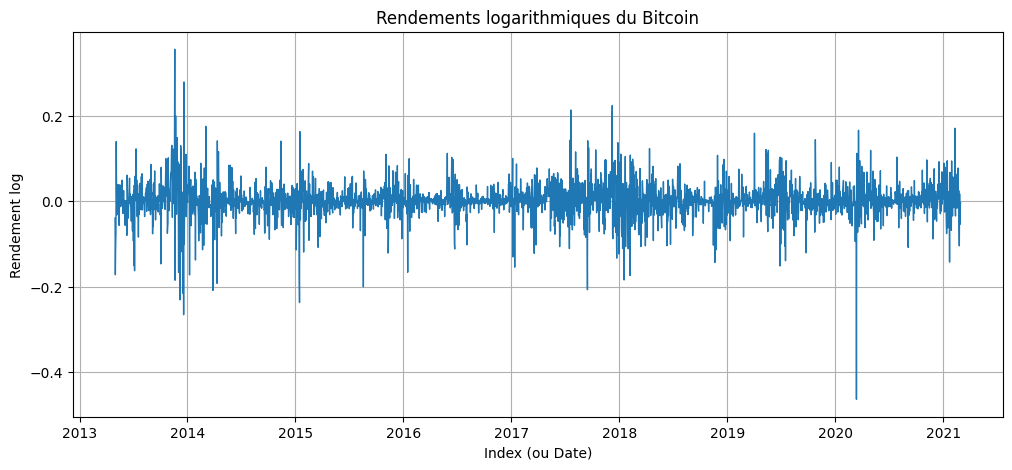

In [64]:
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

# Statistiques descriptives
# Calcul des statistiques descriptives
stats_dict = {
    "Minimum": log_returns.min(),
    "Maximum": log_returns.max(),
    "Moyenne": log_returns.mean(),
    "Écart-type": log_returns.std(),
    "Kurtosis": kurtosis(log_returns, fisher=True)
}

stats_table = pd.DataFrame(stats_dict, index=["Valeur"])

print("\n=== Tableau descriptif complet ===")
print(stats_table)

# Graphique de série temporelle
plt.figure(figsize=(12,5))
plt.plot(log_returns.index, log_returns, linewidth=1)
plt.title("Rendements logarithmiques du Bitcoin")
plt.xlabel("Index (ou Date)")
plt.ylabel("Rendement log")
plt.grid(True)
plt.show()

                           AR - GARCH Model Results                           
Dep. Variable:                  Close   R-squared:                      -0.001
Mean Model:                        AR   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:               -1242.93
Distribution:                  Normal   AIC:                           2497.86
Method:            Maximum Likelihood   BIC:                           2533.61
                                        No. Observations:                 2859
Date:                Thu, Dec 11 2025   Df Residuals:                     2856
Time:                        15:33:44   Df Model:                            3
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0172  6.486e-03      2.653  7.989e

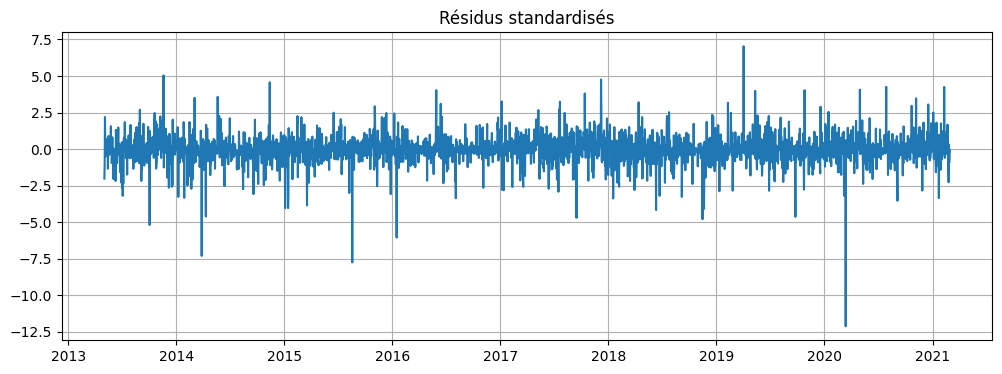

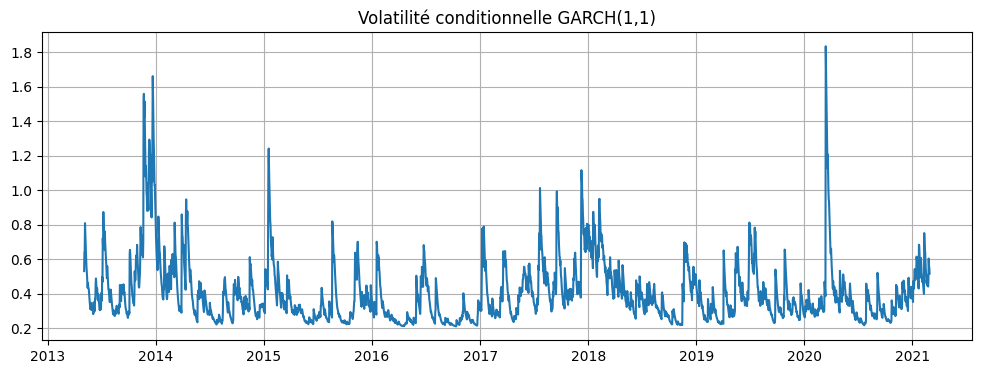

In [65]:
from arch import arch_model

#scale des rendements pour une meilleure convergence
log_returns = 10 * log_returns

# Modèle AR(2)-GARCH(1,1)

model = arch_model(
    log_returns,
    mean="AR",
    lags=2,
    vol="GARCH",
    p=1,
    q=1,
    dist="normal"
)

# Estimation avec erreurs standard classiques (Info Matrix)
res_classic = model.fit(update_freq=0, disp="off", cov_type="classic")

# Estimation avec erreurs standard robustes
res_robust = model.fit(update_freq=0, disp="off", cov_type="robust")

# Tableau des paramètres

tableau = res_robust.summary()
print(tableau)


# Résidus standardisés & volatilité conditionnelle

std_resid = res_classic.std_resid
cond_vol = res_classic.conditional_volatility

plt.figure(figsize=(12,4))
plt.plot(std_resid)
plt.title("Résidus standardisés")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(cond_vol)
plt.title("Volatilité conditionnelle GARCH(1,1)")
plt.grid(True)
plt.show()

In [66]:

# Tableau t-stats : Info Matrix vs Robustes

params = res_classic.params

t_stat_classic = res_classic.params / res_classic.std_err
t_stat_robust = res_robust.params / res_robust.std_err

table = pd.DataFrame({
    "Paramètre": params.index,
    "t-stat (Information Matrix)": t_stat_classic.values,
    "t-stat (Robustes)": t_stat_robust.values
})

print("\nComparaison des t-stats : Info Matrix vs Robustes\n")
print(table.to_string(index=False))


Comparaison des t-stats : Info Matrix vs Robustes

Paramètre  t-stat (Information Matrix)  t-stat (Robustes)
    Const                     2.801568           2.652549
 Close[1]                    -0.091693          -0.064028
 Close[2]                     1.408840           1.401551
    omega                     6.606112           2.708041
 alpha[1]                     8.942515           3.591156
  beta[1]                    49.836367          23.321185


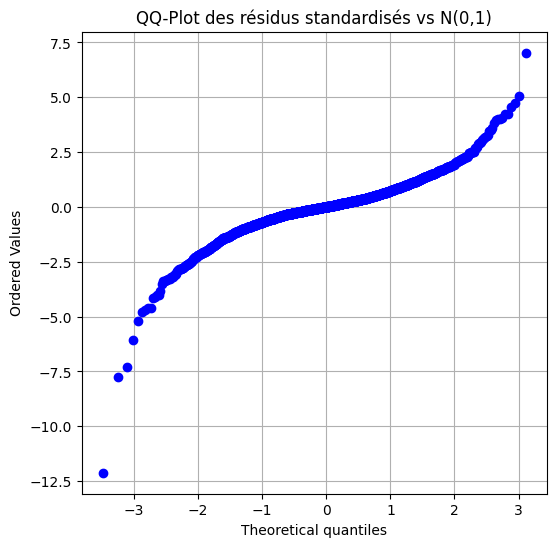

In [67]:
import scipy.stats as stats

# QQ-plot des résidus standardisés vs N(0,1)


plt.figure(figsize=(6,6))
stats.probplot(std_resid, dist="norm", plot=plt)
plt.title("QQ-Plot des résidus standardisés vs N(0,1)")
plt.grid(True)
plt.show()

In [68]:
from scipy.stats import chi2

# 1) Estimation AR(2)-GARCH(1,1) avec erreurs normales (modèle restreint)

#Scale des rendements pour une meilleure convergence


model_norm = arch_model(log_returns, mean="AR", lags=2,
                        vol="GARCH", p=1, q=1, dist="normal")


res_norm = model_norm.fit(disp="off")

# Log-vraisemblance du modèle normal
ll_normal = res_norm.loglikelihood


# 2) Estimation AR(2)-GARCH(1,1) avec erreurs Student-t (modèle non-restreint)

model_t = arch_model(log_returns, mean="AR", lags=2,
                     vol="GARCH", p=1, q=1, dist="t")


res_t = model_t.fit(disp="off", cov_type="robust")

# Log-vraisemblance du modèle Student-t
ll_t = res_t.loglikelihood


# 3) Test du rapport de vraisemblance (LR test)
#    H0 : erreurs normales
#    H1 : erreurs Student-t


# Statistique LR : 2*(LL_non_rest - LL_rest)
LR_stat = 2 * (ll_t - ll_normal)

# Le modèle t ajoute 1 paramètre (degrés de liberté nu)
df = 1

# p-value
p_value = 1 - chi2.cdf(LR_stat, df)




print("Test du rapport de vraisemblance (Normal vs Student-t)")
print(f"Log-L normal      : {ll_normal:.4f}")
print(f"Log-L Student-t   : {ll_t:.4f}")
print(f"Statistique LR    : {LR_stat:.4f}")
print(f"p-value           : {p_value:.4f}")

Test du rapport de vraisemblance (Normal vs Student-t)
Log-L normal      : -1242.9321
Log-L Student-t   : -785.5762
Statistique LR    : 914.7118
p-value           : 0.0000


                             AR - EGARCH Model Results                              
Dep. Variable:                        Close   R-squared:                      -0.002
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                           EGARCH   Log-Likelihood:               -756.127
Distribution:      Standardized Student's t   AIC:                           1528.25
Method:                  Maximum Likelihood   BIC:                           1575.92
                                              No. Observations:                 2859
Date:                      Thu, Dec 11 2025   Df Residuals:                     2856
Time:                              15:33:45   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

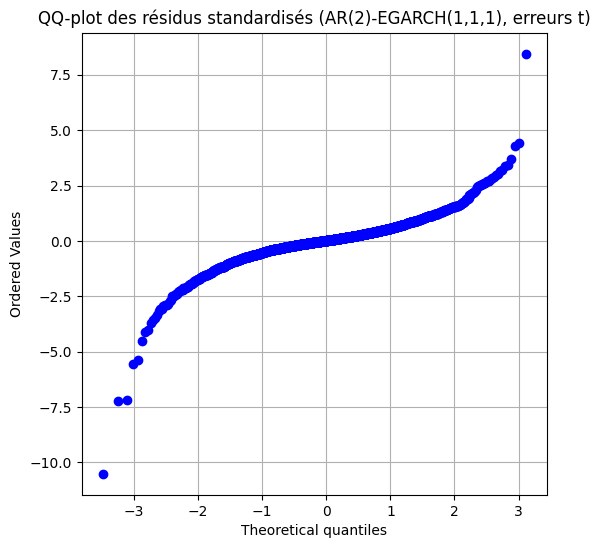

In [69]:

# AR(2)-EGARCH(1,1,1) avec erreurs Student-t

egarch_model = arch_model(
    log_returns,
    mean="AR",
    lags=2,
    vol="EGARCH",
    p=1,   # terme GARCH
    o=1,   # terme asymétrique 
    q=1,   # terme ARCH
    dist="t"
)

egarch_res = egarch_model.fit(disp="off")

# Résumé complet du modèle
print(egarch_res.summary())

# Résidus standardisés du modèle EGARCH

egarch_std_resid = egarch_res.std_resid

# QQ-plot des résidus standardisés vs N(0,1)
plt.figure(figsize=(6, 6))
stats.probplot(egarch_std_resid, dist="norm", plot=plt)
plt.title("QQ-plot des résidus standardisés (AR(2)-EGARCH(1,1,1), erreurs t)")
plt.grid(True)
plt.show()

In [ ]:

# Calcul des AIC et BIC pour les trois modèles estimés

aic_bic_table = pd.DataFrame({
    "Modèle": [
        "AR(2)-GARCH(1,1) Normal",
        "AR(2)-GARCH(1,1) Student-t",
        "AR(2)-EGARCH(1,1,1) Student-t"
    ],
    "AIC": [
        res_norm.aic,
        res_t.aic,
        egarch_res.aic
    ],
    "BIC": [
        res_norm.bic,
        res_t.bic,
        egarch_res.bic
    ]
})

print("\nTableau comparatif AIC / BIC ")
print(aic_bic_table.to_string(index=False))



===== Tableau comparatif AIC / BIC =====
                       Modèle         AIC         BIC
      AR(2)-GARCH(1,1) Normal 2497.864181 2533.613545
   AR(2)-GARCH(1,1) Student-t 1585.152415 1626.860005
AR(2)-EGARCH(1,1,1) Student-t 1528.253038 1575.918856

